In [3]:
# LangGraph
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver

# LangChain
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, AIMessage
from langchain.graphs import Neo4jGraph
from langchain_core.tools import tool
from langchain_groq import ChatGroq

# General
import os
import re
import operator
from uuid import uuid4
from pathlib import Path
from dotenv import load_dotenv
from typing import TypedDict, Annotated # to construct the agent's state
from IPython.display import Image, display

In [2]:
# Get environment variables
dotenv_path = Path('./.env')
load_dotenv(dotenv_path=dotenv_path)

os.environ["NEO4J_URI"] = os.getenv('uri')
os.environ["NEO4J_USERNAME"] = os.getenv('user_name')
os.environ["NEO4J_PASSWORD"] = os.getenv('password')
os.environ["GROQ_API_KEY"] = os.getenv('GROQ_API_KEY')
os.environ["TAVILY_API_KEY"] = os.getenv('TAVILY_API_KEY')

model = ChatGroq(temperature=0.5, groq_api_key=os.environ["GROQ_API_KEY"], model_name="llama-3.1-70b-versatile")
graph = Neo4jGraph()
memory = MemorySaver()

In [ ]:
# class Agent:

#     def __init__(self, model, memory, tools, system=""):
#         self.system = system
#         self.state = AgentState
#         self.memory = memory # initialize
#         self.tools = {t.name: t for t in tools} # Save the tools' names that can be used
#         self.model = model.bind_tools(tools) # Provide the name of the tools to the agent
        
#         graph = StateGraph(self.state) # initialize a stateful graph
#         graph.add_node("llm", self.call_groq) # Add LLM node where we call the LLM to return a reponse
#         graph.add_node("action", self.take_action) # Add node where we call the tools
#         graph.add_edge("action", "llm")
        
#         graph.set_entry_point("llm")
#         graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END}) # The edge where the decision to use a tool is made

#         self.graph = graph.compile(checkpointer=self.memory) # Build graph
#         display(Image(self.graph.get_graph().draw_mermaid_png()))

#     # Get the LLM's response and update the Agent's State by adding the response to the messages
#     def call_groq(self, state: AgentState):
#         messages = state['messages']
#         if self.system: messages = [SystemMessage(content=self.system)] + messages
        
#         message = self.model.invoke(messages)
#         return {'messages': [message]}

#     # Search for the tool and use it
#     def take_action(self, state: AgentState):
#         tool_calls = state['messages'][-1].tool_calls
#         results = []
#         for t in tool_calls:
#             print(f"Calling: {t}")
            
#             # If tool not found
#             if not t['name'] in self.tools: 
#                 print("\n ....tool name not found in list of tools....")
#                 result = "bad tool name, retry"  # instruct LLM to retry
            
#             # If tool exists, use it
#             else:
#                 result = self.tools[t['name']].invoke(t['args']) 

#             # Save the message returned from the tool
#             results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))

#         print("Back to the model!")
#         return {'messages': results}
    
#     # Used by the Agent to check if an action exists by checking the last message in the state which is supposed to contain the tool's info
#     def exists_action(self, state: AgentState):
#         result = state['messages'][-1]
#         return len(result.tool_calls) > 0

In [3]:
## Replaces messages with the same `id`, and appends them otherwise.
def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    # assign ids to messages that don't have ids
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # merge the new messages with the existing messages
    merged = left.copy()
    for message in right:
        for i, existing in enumerate(merged):
            # replace any existing messages with the same id
            if existing.id == message.id:
                merged[i] = message
                break
        else:
            # append any new messages to the end
            merged.append(message)
    return merged

# Create the state of the Agent
class AgentState(TypedDict):
    user_message: str
    personality_traits: list[str]
    occupations: list[str]
    messages: Annotated[list[AnyMessage], reduce_messages]
    max_number_of_questions: int
    number_of_questions_asked: int

In [4]:
## Prepare prompts
personality_scientist_prompt = """You are an expert personality scientist. You are trying to relate personality traits with career tracks.\ 
You will conduct a personality test using the RAISEC personality model\ 
Reminder: R=Realistic, A=Artistic, I=Interrogative, S=Social, E=Enterprising, C=Conventional\ 
Your task is to ask questions that uncover personality traits. \Make sure to cover all the personality traits in RAISEC to get a good understanding of the person's character. After every question you ask, wait for the person to answer.\ Also, number your questions"""

# Extract traits and return list of traits
trait_extractor_prompt = """Go over the person's answer. Extract all the traits that you can in forms of keywords or mini-phrases.\ 
Example: 'I love to work with people Keyword' -> Team-Player or Enjoys Working with Teams.
You will return a list of strings containing all the traits/qualities that you extracted from person's answer.
Example: ['team_player', 'interested_in_psychology','good_listener']"""

# Recommend Careers
career_guide_prompt = """You are now a personality scientist serving as a career guide. Use the list of traits you created to suggest suitable careers for the person. If you have any results from the knowledge graph use them as well."""

# Query KG
cypher_coderer_prompt = """You have access to a Neo4j database. You will write Cypher code to query data from the graph in order to supplement your answer.
Rules when writing Cypher:
- You will not use 'LIMIT'.
- If you don't have the values of nodes' properties in the graph,
you will not use 'WHERE' or try to specify property values. Instead,
you will only use general queries. 
Accepted Example: MATCH (n:label_1)-[]->(m:label_2) return n.prop, m.prop
Rejected Example: MATCH (n:label_1)-[]->(m:label_2) WHERE n.title="Hello" return n.prop, m.prop"""

In [5]:
# Ask questions
def questioner_node(state: AgentState):
  new_messages = [
    SystemMessage(content=personality_scientist_prompt),
    HumanMessage(content=state['user_message'])
  ]
  
  messages = state['messages'] + new_messages

  response = model.invoke(messages)

  # Expected output: new questions
  return {"messages": messages + [response], "number_of_questions_asked": state['number_of_questions_asked'] + 1}

def should_continue(state: AgentState):
  messages_state = state['messages']
  
  if len(messages_state) > 0:
    if messages_state[-1].type == 'ai':
      return False
  
  return True

# Extracts traits and modifies list of traits
def trait_extracter_node(state: AgentState):
  prompt = f"{trait_extractor_prompt}.\ Context of traits so far: {state['personality_traits']}"
  message = [SystemMessage(content=prompt)]
  
  # Expected output: list of traits
  response = model.invoke(message)
  return {"personality_traits": [response]}

# Use traits and occupations to recommend careers
def career_guide_node(state: AgentState):
  prompt = f"{career_guide_prompt}.\ Context of traits so far: {state['personality_traits']}. Context of occpuations so far: {state['occupations']}"
  message = [SystemMessage(content=prompt)]

  response = model.invoke(message)
  return {}

In [ ]:
# # Create the tool to be used by the Agent
# @tool
# def query_graph(query):
#   """Query from Neo4j knowledge graph using Cypher."""
#   return graph.query(query)

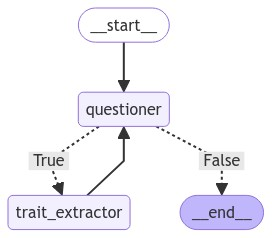

In [6]:
builder = StateGraph(AgentState)

builder.add_node('questioner', questioner_node)
builder.add_node('trait_extractor', trait_extracter_node)

builder.set_entry_point('questioner')
builder.add_edge('trait_extractor', 'questioner')

builder.add_conditional_edges('questioner', should_continue, {True: 'trait_extractor', False: END})

graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
history_messages = []

In [25]:
thread = {"configurable": {"thread_id": "1"}}
for message in graph.stream({'user_message': "Sure", "max_number_of_questions": 2, "number_of_questions_asked": 0}, thread):
  history_messages.append(message)

print(graph.get_state(thread).values['messages'][-1].content)

Based on your personality traits, here are some career tracks that might be a good fit for you:

1. **Teacher/Professor**: Your Social (S) tendencies, combined with your Artistic (A) and Investigative (I) traits, make you well-suited for a career in education. You'd enjoy sharing your knowledge and inspiring others, and your creative approach would make your teaching style engaging and interactive.
2. **Counselor/Therapist**: Your empathetic and caring nature (Social) would serve you well in a role where you help people navigate personal challenges. Your Investigative (I) tendencies would also help you analyze complex issues and develop effective solutions.
3. **Designer/Architect**: Your Artistic (A) and Realistic (R) traits make you a strong candidate for a career in design or architecture. You'd enjoy bringing creative ideas to life, and your hands-on approach would serve you well in working with physical materials and tools.
4. **Project Manager**: Your Conventional (C) tendencies,

: 

In [23]:
# graph.get_state(thread).values['messages']
print(graph.get_state(thread).values['messages'][-1].content)

Your response suggests that you might have a strong Realistic (R) component in your personality. People with Realistic tendencies often enjoy working with physical materials, tools, and equipment, and tend to be practical and hands-on in their approach.

Here's my next question:

6. When interacting with others, how important is it for you to help them and make a positive impact on their lives? Do you tend to be empathetic and caring, enjoying roles that involve supporting and guiding others, or are you more focused on your own goals and priorities?

(Note: This question is designed to assess your Social (S) tendencies.)


In [ ]:
agent.graph.get_state({"configurable": {"thread_id": "1"}}).values

In [ ]:
# Talk to the AI
thread = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="Can you change your questions?")

output = agent.graph.stream(input={"messages": [input_message]}, config=thread, stream_mode="values")


# Pretty printing the ai's output
for event in output: 
  event["messages"][-1].pretty_print()

In [ ]:
## Attempt to change the query written by the AI: Success
# Save the current state as a variable
current_values = agent.graph.get_state(thread)

# Get the id of the thing to change
_id = current_values.values['messages'][-3].tool_calls[0]['id']

# Change the value
current_values.values['messages'][-3].tool_calls = [
  {'name': 'query_graph',
   'args': {'query': 'Match (o:Occupation)-[:need_for_personality_trait]->(t:Personality_Trait) WHERE t.title in [Social, Investigative] return o.title, t.title'},
   'id': _id
   }
]

# Update the state
agent.graph.update_state(thread, current_values.values)

In [ ]:
# Attempting to remove the last two messages from the state: Failed
current_values.values['messages'] = current_values.values['messages'][:-2]

agent.graph.update_state(thread, current_values.values)

In [ ]:
## Attempting to remove values from the ToolMessage returned from the graph's query: Success

# Get the id of the tool message
_id = agent.graph.get_state(thread).values['messages'][-2].id

# Loop over the messages in the Agent's State, find the ToolMessage through its id, change its value, append the message to the messages list
messages = []
for message in agent.graph.get_state(thread).values['messages']:
  if message.id == _id:
    message.content = '[{\'o.title\': \'School_Psychologists\', \'t.title\': \'Conventional\'}, {\'o.title\': \'Film_and_Video_Editors\', \'t.title\': \'Conventional\'}]'

  messages.append(message)

# Change messages list into a dictionary similar to get_state's .values dictionary.
messages = {'messages': messages}

# Update the state
agent.graph.update_state(thread, messages)

In [ ]:
agent.graph.get_state(thread).values